# DeepDream

DeepDream là một thí nghiệm hình dung các mẫu được học bởi một mạng nơ-ron. Tương tự như khi một đứa trẻ nhìn các đám mây và cố gắng diễn giải các hình dạng ngẫu nhiên, DeepDream quá giải thích và tăng cường các mẫu mà nó nhìn thấy trong một hình ảnh.

Điều này được thực hiện bằng cách đưa một hình ảnh qua mạng nơ-ron, sau đó tính toán độ dốc của hình ảnh đối với các kích hoạt của một lớp cụ thể. Sau đó, hình ảnh được sửa đổi để tăng các kích hoạt này, tăng cường các mẫu được nhìn thấy bởi mạng nơ-ron và dẫn đến một hình ảnh giống như trong giấc mơ. Quá trình này được gọi là "Inceptionism" (một tham chiếu đến InceptionNet và bộ phim Inception).

Hãy thử nghiệm cách bạn có thể làm cho một mạng nơ-ron "mơ mộng" và tăng cường các mẫu kỳ lạ mà nó nhìn thấy trong một hình ảnh.







In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

## Chọn ảnh để dream-ify

In [ ]:
url = 'https://thegioihoihoa.com/cdn/shop/articles/tranh-hoa-dien-vi-irises-vincent-van-gogh_1428x.jpg?v=1681598391'

244847/244847 [==============================] - 0s 0us/step


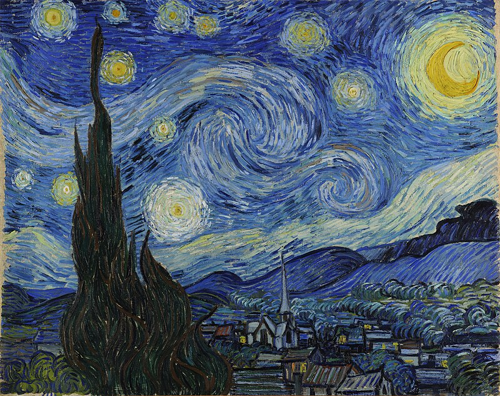

In [ ]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)


## Chuẩn bị mô hình trích xuất đặc trưng




Hãy tải về và chuẩn bị một mô hình phân loại ảnh đã được huấn luyện trước. Bạn sẽ sử dụng InceptionV3, một mô hình tương tự với mô hình được sử dụng ban đầu trong DeepDream. Lưu ý rằng bất kỳ mô hình đã được huấn luyện trước nào cũng có thể hoạt động, tuy nhiên bạn sẽ phải điều chỉnh tên các lớp bên dưới nếu bạn thay đổi điều này.

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step



Ý tưởng trong DeepDream là chọn một lớp (hoặc các lớp) và tối đa hóa "mất mát" một cách sao cho hình ảnh ngày càng "kích thích" các lớp. Sự phức tạp của các đặc điểm được tích hợp phụ thuộc vào các lớp bạn chọn, tức là các lớp ở phía dưới tạo ra các nét vẽ hoặc mẫu đơn giản, trong khi các lớp sâu hơn cung cấp các đặc điểm phức tạp trong hình ảnh, hoặc thậm chí là toàn bộ đối tượng.

Kiến trúc của InceptionV3 khá lớn (để xem biểu đồ kiến trúc mô hình, hãy xem trong kho lưu trữ nghiên cứu của TensorFlow). Đối với DeepDream, các lớp quan tâm là những lớp mà các tích chập được nối tiếp. Có 11 lớp như vậy trong InceptionV3, có tên là 'mixed0' đến 'mixed10'. Sử dụng các lớp khác nhau sẽ dẫn đến các hình ảnh giống như trong giấc mơ khác nhau. Các lớp sâu hơn phản ứng với các đặc điểm ở mức cao hơn (như mắt và khuôn mặt), trong khi các lớp sớm hơn phản ứng với các đặc điểm đơn giản hơn (như cạnh, hình dạng và cấu trúc). Hãy thoải mái thử nghiệm với các lớp được chọn dưới đây, nhưng hãy nhớ rằng các lớp sâu hơn (có chỉ số cao hơn) sẽ mất thời gian lâu hơn để huấn luyện vì tính toán độ dốc sâu hơn.

In [ ]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Tính toán sự mất mát


Mất mát là tổng của các kích hoạt trong các lớp được chọn. Mất mát được chuẩn hóa tại mỗi lớp để đóng góp từ các lớp lớn hơn không vượt quá các lớp nhỏ hơn. Thông thường, mất mát là một đại lượng bạn muốn giảm thiểu thông qua gradient descent. Trong DeepDream, bạn sẽ tối đa hóa mất mát này thông qua gradient ascent.

In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)


Khi bạn đã tính toán mất mát cho các lớp đã chọn, tất cả những gì còn lại là tính toán các độ dốc đối với hình ảnh và thêm chúng vào hình ảnh gốc.

Việc thêm các độ dốc vào hình ảnh tăng cường các mẫu được nhìn thấy bởi mạng. Tại mỗi bước, bạn sẽ đã tạo ra một hình ảnh ngày càng kích thích các kích hoạt của các lớp nhất định trong mạng.

Phương pháp thực hiện điều này, dưới đây, được bao bọc trong một tf.function để tăng hiệu suất. Nó sử dụng input_signature để đảm bảo rằng hàm không được truy vấn lại cho các kích thước hình ảnh khác nhau hoặc các giá trị bước / step_size khác nhau. Xem hướng dẫn về các hàm Concrete để biết chi tiết.

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

## Vòng lặp chính


In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

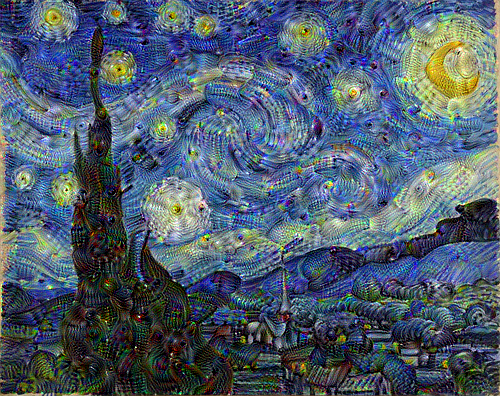

In [ ]:
dream_img = run_deep_dream_simple(img=original_img,
                                  steps=100, step_size=0.01)


Có vài vấn đề với bản thử đầu tiên này:

Kết quả có nhiễu (điều này có thể được giải quyết bằng cách sử dụng mất mát tf.image.total_variation).
Độ phân giải của hình ảnh thấp.
Các mẫu xuất hiện như đang xảy ra ở cùng một độ tinh mịch.
Một phương pháp giải quyết tất cả các vấn đề này là áp dụng gradient ascent ở các tỷ lệ khác nhau. Điều này sẽ cho phép các mẫu được tạo ra ở các tỷ lệ nhỏ được tích hợp vào các mẫu ở các tỷ lệ lớn hơn và được bổ sung thêm chi tiết.

Để làm điều này, bạn có thể thực hiện phương pháp gradient ascent trước đó, sau đó tăng kích thước của hình ảnh (được gọi là một "octave"), và lặp lại quá trình này cho nhiều octave.

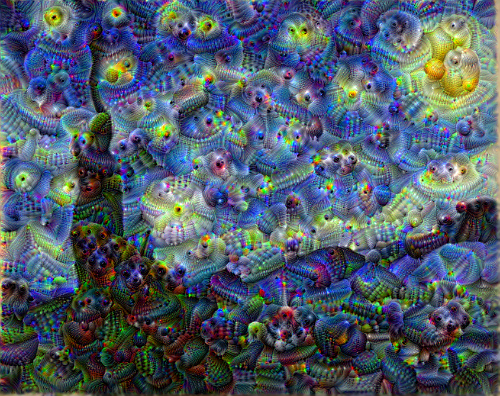

18.6589777469635

In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start


Một điều cần xem xét là khi hình ảnh tăng kích thước, thì thời gian và bộ nhớ cần thiết để thực hiện tính toán gradient cũng sẽ tăng lên. Cài đặt octave ở trên sẽ không hoạt động trên các hình ảnh rất lớn hoặc nhiều octave.

Để tránh vấn đề này, bạn có thể chia hình ảnh thành các ô và tính toán gradient cho mỗi ô.

Áp dụng các dịch chuyển ngẫu nhiên vào hình ảnh trước mỗi tính toán trên từng ô ngăn ngừa việc xuất hiện các đường nối ô.

Bắt đầu bằng cách triển khai việc dịch chuyển ngẫu nhiên:

In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

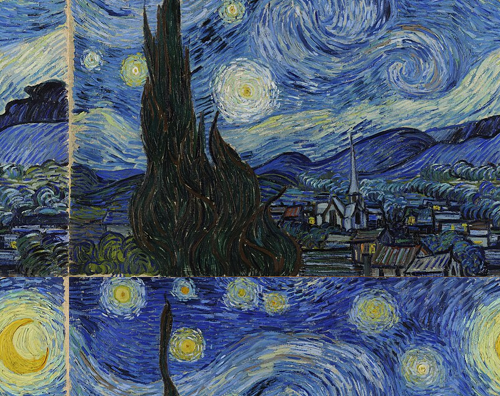

In [ ]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)


Dưới đây là một phiên bản chia thành các ô tương đương của hàm deepdream được định nghĩa trước đó:

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8

    return gradients

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

Kết hợp tất cả lại, chúng ta có một phương pháp DeepDream có thể mở rộng và nhận biết các octave:
---

implementation:

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01,
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

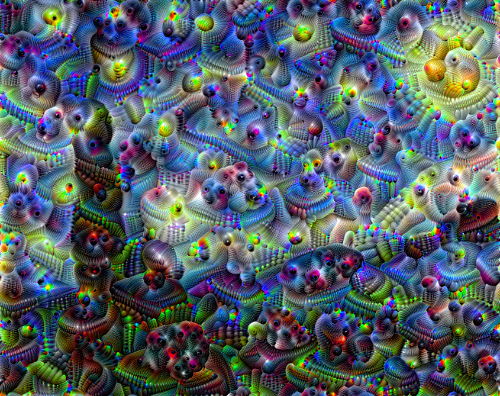

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)


thử nghiệm với số lượng octave, tỷ lệ octave và các lớp được kích hoạt

